In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

bitcoin = yf.download("BTC-USD",start="2010-05-17",end="2025-06-17")['Close']
bitcoin = bitcoin.shift(1)
bitcoin.dropna(inplace=True)
bitcoin = bitcoin.reset_index()



cuda:0
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


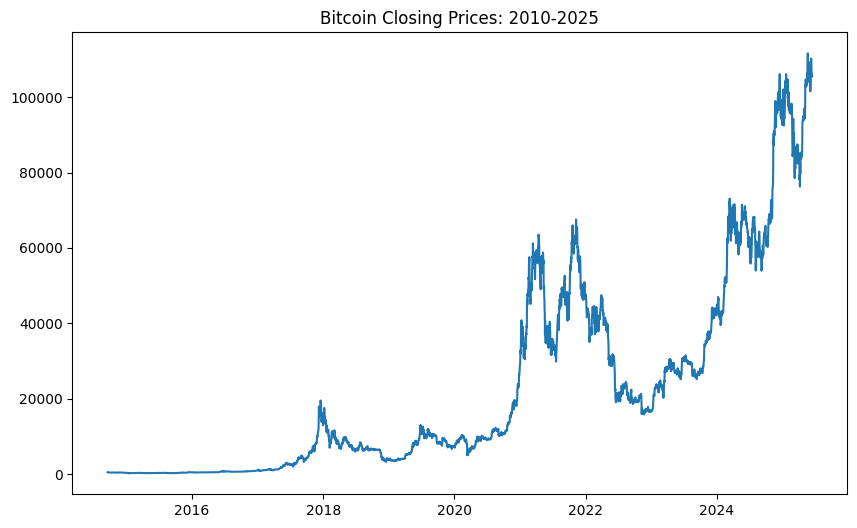

In [2]:
plt.figure(figsize=(10,6))
plt.plot(bitcoin['Date'],bitcoin['BTC-USD'])
plt.title("Bitcoin Closing Prices: 2010-2025")
plt.savefig("images/closing_prices.png")
plt.show()

In [3]:

training = bitcoin.iloc[:,1:2].values

train_size = int(len(training)* 0.80)

train_data = training[:train_size]
test_data = training[train_size:]
print(len(train_data))
print(len(test_data))


3140
785


In [4]:

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [5]:


def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        X_ = dataframe[i:(seq_length + i)]
        y_ = dataframe[(seq_length + i)]
        X.append(X_)
        y.append(y_)
    return np.array(X),np.array(y)

seq_length = 1
X_train,y_train = slider(train_data,seq_length)
X_test,y_test = slider(test_data,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [6]:


class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=64,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_fn = nn.MSELoss()
epochs = 1000

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_6384\189076980.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_6384\189076980.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2463; Test RSME: 0.8599
Epoch: 1; train_RSEM: 0.2436; Test RSME: 0.8494
Epoch: 2; train_RSEM: 0.2411; Test RSME: 0.8388
Epoch: 3; train_RSEM: 0.239; Test RSME: 0.8284
Epoch: 4; train_RSEM: 0.2372; Test RSME: 0.818
Epoch: 5; train_RSEM: 0.2356; Test RSME: 0.8078
Epoch: 6; train_RSEM: 0.2344; Test RSME: 0.798
Epoch: 7; train_RSEM: 0.2333; Test RSME: 0.7885
Epoch: 8; train_RSEM: 0.2325; Test RSME: 0.7796
Epoch: 9; train_RSEM: 0.2318; Test RSME: 0.7713
Epoch: 10; train_RSEM: 0.2311; Test RSME: 0.7639
Epoch: 11; train_RSEM: 0.2305; Test RSME: 0.7573
Epoch: 12; train_RSEM: 0.2298; Test RSME: 0.7516
Epoch: 13; train_RSEM: 0.229; Test RSME: 0.7468
Epoch: 14; train_RSEM: 0.2281; Test RSME: 0.7428
Epoch: 15; train_RSEM: 0.2272; Test RSME: 0.7396
Epoch: 16; train_RSEM: 0.2261; Test RSME: 0.737
Epoch: 17; train_RSEM: 0.2249; Test RSME: 0.7349
Epoch: 18; train_RSEM: 0.2237; Test RSME: 0.7332
Epoch: 19; train_RSEM: 0.2225; Test RSME: 0.7319
Epoch: 20; train_RSEM: 0.2213; Test

In [7]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = bitcoin.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))


         Date  Actual Price  Predicted Price
0  2023-04-25  27525.341797     27620.935547
1  2023-04-26  28307.597656     27554.714844
2  2023-04-27  28422.701172     28339.013672
3  2023-04-28  29473.787109     28454.412109
4  2023-04-29  29340.261719     29508.042969
5  2023-04-30  29248.488281     29374.210938
6  2023-05-01  29268.806641     29282.218750
7  2023-05-02  28091.568359     29302.585938
8  2023-05-03  28680.539062     28122.433594
9  2023-05-04  29006.308594     28712.892578
10 2023-05-05  28847.710938     29039.458984
11 2023-05-06  29534.384766     28880.476562
12 2023-05-07  28904.623047     29568.783203
13 2023-05-08  28454.980469     28937.525391
14 2023-05-09  27694.275391     28486.769531
15 2023-05-10  27658.775391     27724.097656
16 2023-05-11  27621.757812     27688.505859
17 2023-05-12  27000.791016     27651.388672
18 2023-05-13  26804.992188     27028.744141
19 2023-05-14  26784.078125     26832.406250
          Date   Actual Price  Predicted Price
763 2025

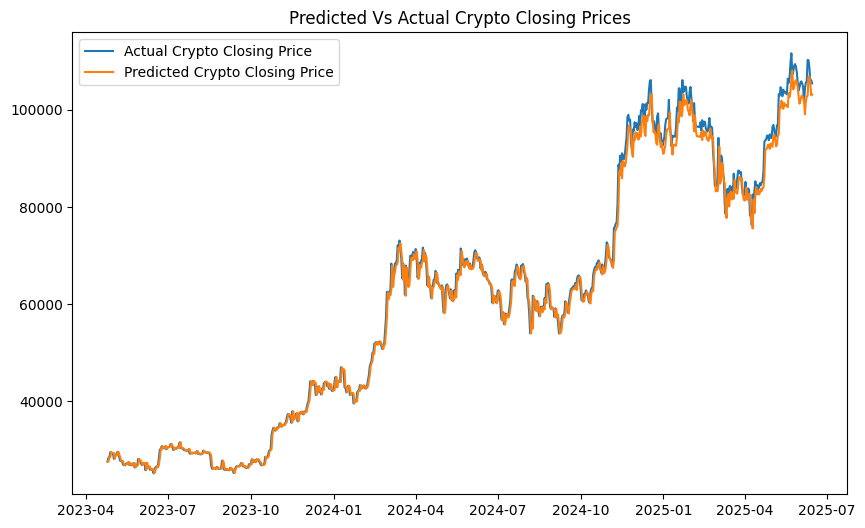

In [8]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df['Actual Price'],label="Actual Crypto Closing Price")
plt.plot(comparison_df['Date'],comparison_df['Predicted Price'],label="Predicted Crypto Closing Price")
plt.title("Predicted Vs Actual Crypto Closing Prices")
plt.savefig("images/predicted_vs_actual_closing_prices")
plt.legend()
plt.show()





